<a href="https://colab.research.google.com/github/Jesteban247/ML-College/blob/main/Tech_ML/Assignments/Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **K-Means Clustering Algorithm from Scratch**

## Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import zipfile

## Load and Explore Data

In [2]:
# Download the dataset
!kaggle datasets download imakash3011/customer-personality-analysis

Dataset URL: https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis
License(s): CC0-1.0
  0% 0.00/62.0k [00:00<?, ?B/s]
100% 62.0k/62.0k [00:00<00:00, 51.4MB/s]


In [3]:
# Extract the zip file
with zipfile.ZipFile('/content/customer-personality-analysis.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

# Open the CSV file with the specified separator
df = pd.read_csv('/content/marketing_campaign.csv', sep='\t')

# View the first few rows of the dataset
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [4]:
# Check data types and missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [5]:
# Check for null values in each column
print("\nNull values in each column:\n", df.isnull().sum())


Null values in each column:
 ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64


In [6]:
# Handling missing values for 'Income' by filling with the median
median_income = df['Income'].median()
df['Income'] = df['Income'].fillna(median_income)

In [7]:
# Descibe the df
df.describe()

,ID,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
count,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,...,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.0,2240.0,2240.000000
mean,5592.159821,1968.805804,52237.975446,0.444196,0.506250,49.109375,303.935714,26.302232,166.950000,37.525446,...,5.316518,0.072768,0.074554,0.072768,0.064286,0.013393,0.009375,3.0,11.0,0.149107
std,3246.662198,11.984069,25037.955891,0.538398,0.544538,28.962453,336.597393,39.773434,225.715373,54.628979,...,2.426645,0.259813,0.262728,0.259813,0.245316,0.114976,0.096391,0.0,0.0,0.356274
min,0.000000,1893.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
25%,2828.250000,1959.000000,35538.750000,0.000000,0.000000,24.000000,23.750000,1.000000,16.000000,3.000000,...,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
50%,5458.500000,1970.000000,51381.500000,0.000000,0.000000,49.000000,173.500000,8.000000,67.000000,12.000000,...,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
75%,8427.750000,1977.000000,68289.750000,1.000000,1.000000,74.000000,504.250000,33.000000,232.000000,50.000000,...,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
max,11191.000000,1996.000000,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,...,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.0,11.0,1.000000


## Feature Engineering

In [8]:
# Calculate 'Age' from 'Year_Birth'
df['Age'] = 2024 - df['Year_Birth']

# Create 'Family_Size' by adding 'Kidhome' and 'Teenhome'
df['Family_Size'] = df['Kidhome'] + df['Teenhome']

# Create 'Spending' by summing product amounts
df['Spending'] = df['MntWines'] + df['MntFruits'] + df['MntMeatProducts'] + df['MntFishProducts'] + df['MntSweetProducts'] + df['MntGoldProds']

# Create 'TotalCampaignsAccepted' by summing accepted campaigns
df['TotalCampaignsAccepted'] = df[['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']].sum(axis=1)

# Create 'Tenure' as the number of days since 'Dt_Customer'
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%d-%m-%Y') # Specify the correct format: DD-MM-YYYY
df['Tenure'] = (pd.to_datetime('today') - df['Dt_Customer']).dt.days

In [9]:
# Replace 'Education' with numerical IDs using factorize
df['Education'], education_mapping = pd.factorize(df['Education'])

# Show the mapping for 'Education'
print("Education Mapping:")
for idx, category in enumerate(education_mapping):
    print(f"{idx}: {category}")

# Replace 'Marital_Status' with numerical IDs using factorize
df['Marital_Status'], marital_status_mapping = pd.factorize(df['Marital_Status'])

# Show the mapping for 'Marital_Status'
print("\nMarital Status Mapping:")
for idx, category in enumerate(marital_status_mapping):
    print(f"{idx}: {category}")

Education Mapping:
0: Graduation
1: PhD
2: Master
3: Basic
4: 2n Cycle

Marital Status Mapping:
0: Single
1: Together
2: Married
3: Divorced
4: Widow
5: Alone
6: Absurd
7: YOLO


In [10]:
# Select the final columns for clustering
columns_to_keep = ['Age', 'Income', 'Family_Size', 'Recency', 'Spending',
                   'TotalCampaignsAccepted', 'NumDealsPurchases', 'NumWebPurchases',
                   'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
                   'Complain', 'Tenure', 'Education', 'Marital_Status']

df = df[columns_to_keep]

df.head()

,Age,Income,Family_Size,Recency,Spending,TotalCampaignsAccepted,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Complain,Tenure,Education,Marital_Status
0,67,58138.0,0,58,1617,0,3,8,10,4,7,0,4429,0,0
1,70,46344.0,2,38,27,0,2,1,1,2,5,0,3879,0,0
2,59,71613.0,0,26,776,0,1,8,2,10,4,0,4078,0,1
3,40,26646.0,1,26,53,0,2,2,0,4,6,0,3905,0,1
4,43,58293.0,1,94,422,0,5,5,3,6,5,0,3927,1,2


In [11]:
# Remove outliers
# Filtering out customers with very high income and age greater than 90
df = df[(df['Income'] <= 100000) & (df['Age'] <= 90)]

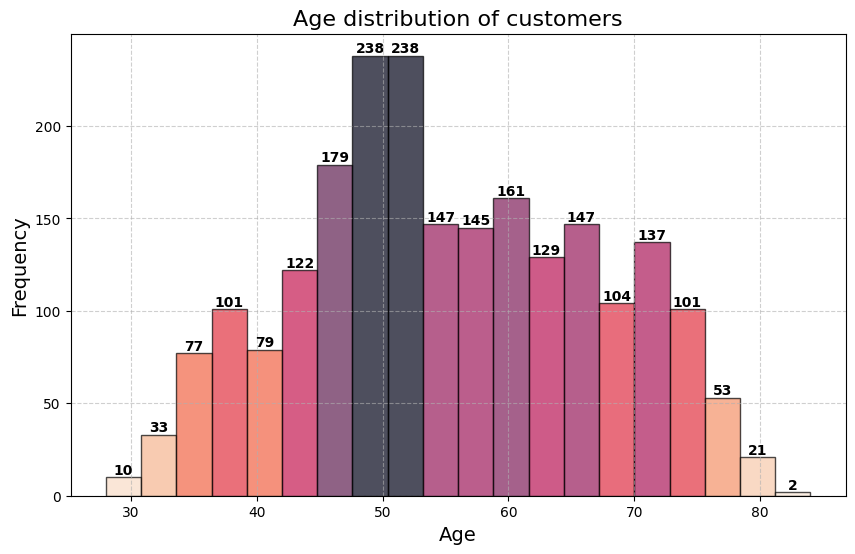

In [12]:
# Age Distribution
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(df['Age'], bins=20, color='blue', alpha=0.7, edgecolor='black')
for i in range(len(patches)):
    patches[i].set_facecolor(sns.color_palette("rocket_r", as_cmap=True)(n[i] / max(n)))
    if n[i] > 0:
        plt.text(patches[i].get_x() + patches[i].get_width() / 2, n[i], int(n[i]), ha='center', va='bottom', fontsize=10, fontweight='bold')
plt.title('Age distribution of customers', fontsize=16)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

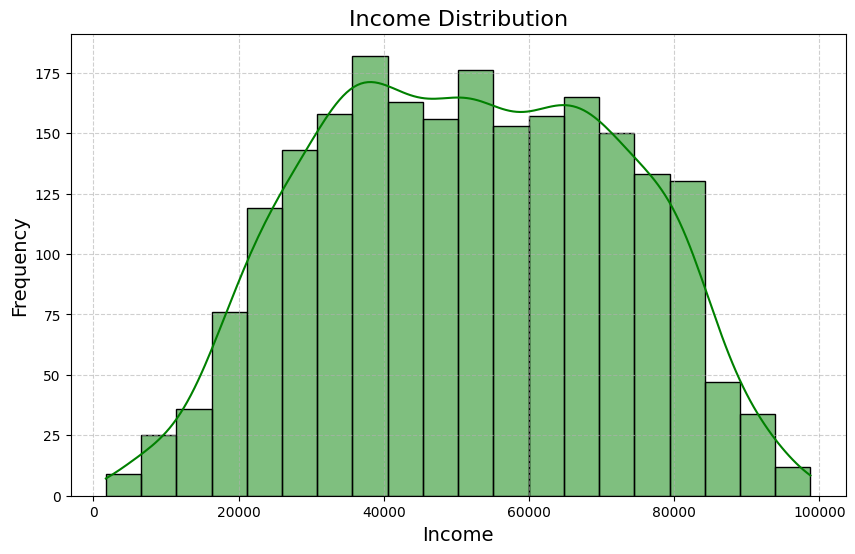

In [13]:
# Income Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['Income'], kde=True, color='green')
plt.title('Income Distribution', fontsize=16)
plt.xlabel('Income', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

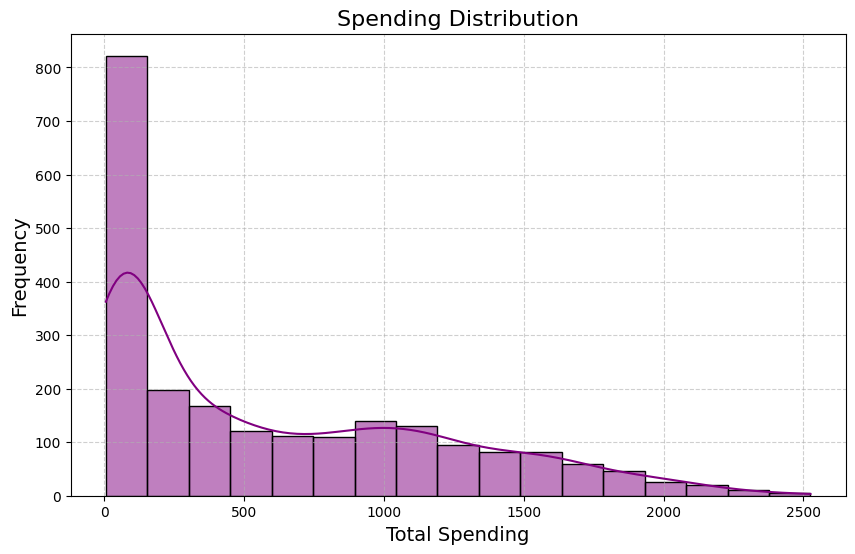

In [14]:
# Spendings Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['Spending'], kde=True, color='purple')
plt.title('Spending Distribution', fontsize=16)
plt.xlabel('Total Spending', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Cumulative Explained Variance:
PC 1: 0.2921
PC 2: 0.4142
PC 3: 0.4960
PC 4: 0.5661
PC 5: 0.6324
PC 6: 0.6974
PC 7: 0.7604
PC 8: 0.8178
PC 9: 0.8697
PC 10: 0.9075
PC 11: 0.9366
PC 12: 0.9623
PC 13: 0.9798
PC 14: 0.9927
PC 15: 1.0000


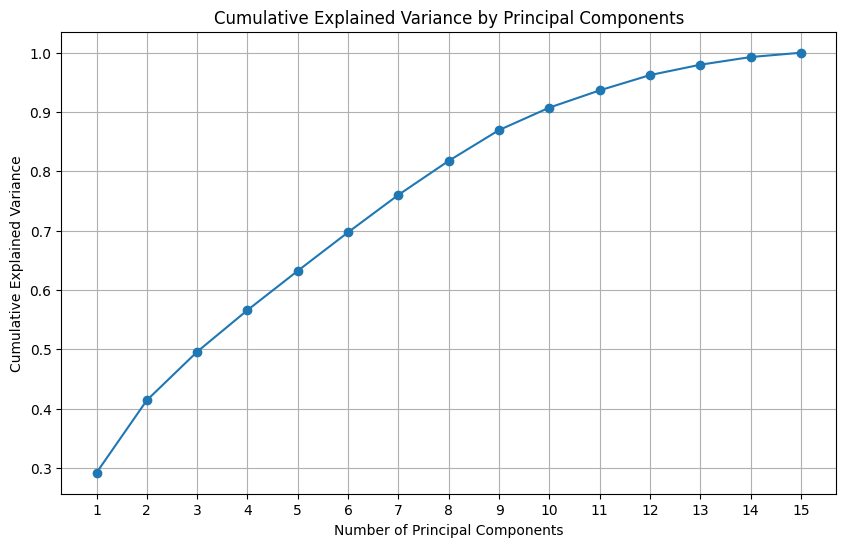

In [15]:
# Perform PCA
X = df.copy()

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Explained variance ratio for each principal component
explained_variance_ratio = pca.explained_variance_ratio_

# Cumulative explained variance
cumulative_variance = [sum(explained_variance_ratio[:i + 1]) for i in range(len(explained_variance_ratio))]

# Show the cumulative variance
print("Cumulative Explained Variance:")
for i, variance in enumerate(cumulative_variance):
    print(f"PC {i + 1}: {variance:.4f}")

# Plot the cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Principal Components')
plt.grid(True)
plt.xticks(range(1, len(cumulative_variance) + 1))
plt.show()

In customer segmentation analysis, PCA (Principal Component Analysis) was initially considered for dimensionality reduction. However, while PCA can effectively reduce features, it does not retain enough interpretability when limited to just 2 or 3 components, often resulting in lost insights.

To address this, the analysis shifted focus to selecting key features based on their relevance to customer behavior. The top features identified were:

- **Top 2 Features**:
  - **Income**: Critical for understanding customer spending power.
  - **Spending**: Directly indicates customer engagement.

- **Top 3 Features**:
  - **Income**: As above.
  - **Spending**: As above.
  - **Recency**: Indicates customer loyalty based on recent purchases.

Consequently, three DataFrames were created:
1. **DataFrame with 15 Features**: Retains all original features.
2. **DataFrame with Top 2 Features**: Focuses on `Income` and `Spending`.
3. **DataFrame with Top 3 Features**: Includes `Income`, `Spending`, and `Recency`.

This approach ensures a more actionable and focused analysis for customer segmentation.

In [16]:
# Selecting the top 2 and top 3 features for clustering analysis
top_2_features = ['Income', 'Spending']
top_3_features = ['Income', 'Spending', 'Recency']

# Create DataFrames for top features
df_top_2 = df[top_2_features]
df_top_3 = df[top_3_features]

# Output the selected features for clustering
print("Top 2 Features for Clustering:")
print(df_top_2.head())

print("\nTop 3 Features for Clustering:")
print(df_top_3.head())

Top 2 Features for Clustering:
    Income  Spending
0  58138.0      1617
1  46344.0        27
2  71613.0       776
3  26646.0        53
4  58293.0       422

Top 3 Features for Clustering:
    Income  Spending  Recency
0  58138.0      1617       58
1  46344.0        27       38
2  71613.0       776       26
3  26646.0        53       26
4  58293.0       422       94


## K-Means

**Step-by-Step Process of K-Means**

1. **Choose the number of clusters (k)**  
   The first step in the K-Means algorithm is to decide how many clusters, denoted by "k", are needed. This number is provided as input by the user. The value of k dictates how many groupings the data will be divided into.

2. **Initialize centroids randomly**  
   The algorithm randomly selects k points from the dataset or generates k centroids within the range of the data. These centroids serve as the initial centers of the clusters. At the beginning, these centroids are just estimates of where the center of each cluster should be.

3. **Assign each point to the nearest centroid**  
   For each data point, the algorithm calculates its distance to all k centroids. The distance is typically measured using **Euclidean distance** (the straight-line distance between two points). After computing the distances, each data point is assigned to the cluster whose centroid is closest to it. At this stage, all points are grouped based on proximity to the centroids.

4. **Recalculate centroids**  
   Once all data points have been assigned to a cluster, the algorithm updates the centroids. The new centroid for each cluster is calculated as the **mean** (average) of all the data points that belong to that cluster. This step adjusts the centroids to better represent the center of their respective clusters.

5. **Repeat the process**  
   Steps 3 (assigning points to centroids) and 4 (recalculating centroids) are repeated. In each iteration, data points are reassigned to the nearest updated centroid, and the centroids are recalculated based on the new groupings. This iterative process continues until the centroids no longer change significantly between iterations.

6. **Check for convergence**  
   The algorithm checks if the centroids have **converged**, meaning they no longer move or change positions between iterations. If the centroids remain the same, the algorithm stops. Otherwise, it continues to iterate. Convergence usually indicates that the clustering process is complete, and the clusters are stable.

7. **Output final clusters**  
   Once convergence is reached, the final set of centroids and the assignment of data points to clusters are produced as the result. The data is now grouped into k clusters, with each point assigned to the cluster whose centroid is closest to it.


In [17]:
def init_centroids(X, k, verbose=False):
    n_features = X.shape[1]
    centroids = np.zeros((k, n_features))

    # For each feature, pick random values within the range of that feature's data
    for i in range(n_features):
        min_val = np.min(X[:, i])  # Minimum value in the i-th feature
        max_val = np.max(X[:, i])  # Maximum value in the i-th feature
        centroids[:, i] = np.random.uniform(min_val, max_val, size=k)  # Random values for centroids

    if verbose:
        print(f"Initial centroids:\n{centroids}\n")
    return centroids

In [18]:
def closest_point(X, centroids, verbose=False):
    # Calculate distances between each data point and each centroid using Euclidean distance
    distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)

    # Get the index of the nearest centroid for each data point
    closest = np.argmin(distances, axis=1)

    # Get the minimum distance (nearest centroid) for each data point
    min_distances = np.min(distances, axis=1)

    if verbose:
        print(f"Closest centroid for each point:\n{closest}\n")
        print(f"Distances to closest centroids:\n{min_distances}\n")

    return closest, min_distances

In [19]:
def new_centers(X, labels, k, verbose=False):
    new_centroids = np.zeros((k, X.shape[1]))

    for i in range(k):
        # Calculate the new centroid for each cluster
        if np.any(labels == i):  # Only compute if there are points in the cluster
            new_centroids[i] = X[labels == i].mean(axis=0)
        else:
            # If no points assigned to cluster i, keep the old centroid
            if verbose:
                print(f"Cluster {i} has no assigned points. Keeping old centroid.")

    if verbose:
        print(f"New centroids after updating:\n{new_centroids}\n")

    return new_centroids

In [20]:
def kmeans(X, k, max_iters=100, verbose=False):
    centroids = init_centroids(X, k, verbose)

    # Iterate to update centroids and labels until convergence or max iterations
    for i in range(max_iters):
        if verbose:
            print(f"Iteration {i + 1}:\n")

        # Assign each point to the nearest centroid
        labels, _ = closest_point(X, centroids, verbose)

        # Recompute the centroids based on the current assignment
        new_centroids = new_centers(X, labels, k, verbose)

        # Check for convergence (if centroids didn't change, stop)
        if np.all(centroids == new_centroids):
            if verbose:
                print(f"Centroids have converged at iteration {i + 1}.\n")
            break

        centroids = new_centroids  # Update centroids for the next iteration

    return centroids, labels

In [21]:
# Function to calculate WCSS for different values of k
def calculate_wcss(X, max_k):
    wcss = []
    for k in range(1, max_k + 1):
        centroids, labels = kmeans(X, k)
        total_wcss = 0
        for i in range(k):
            if np.any(labels == i):  # Check if there are points assigned to the cluster
                total_wcss += np.sum((X[labels == i] - centroids[i]) ** 2)  # Sum the squared distances
        wcss.append(total_wcss)
    return wcss

## Example with Synthetic 2D Data

In [22]:
np.random.seed(42)

# Generate 3 clusters of random points in 2D
X = np.vstack([
    np.random.randn(100, 2) + [3, 3],   # Cluster 1 centered around [3, 3]
    np.random.randn(100, 2) + [-3, -3], # Cluster 2 centered around [-3, -3]
    np.random.randn(100, 2)             # Cluster 3 centered around [0, 0]
])

In [23]:
X.shape

(300, 2)

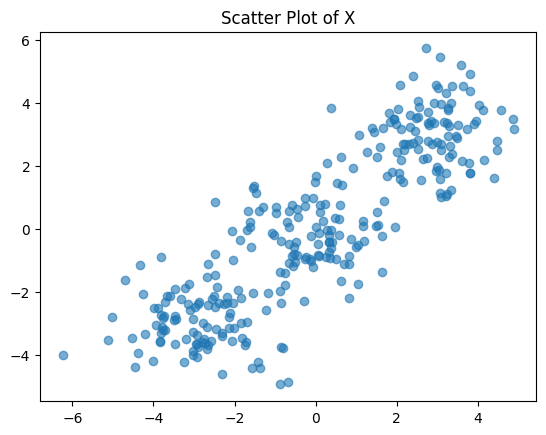

In [24]:
plt.scatter(X[:, 0], X[:, 1], marker='o', alpha=0.6)
plt.title("Scatter Plot of X")
plt.show()

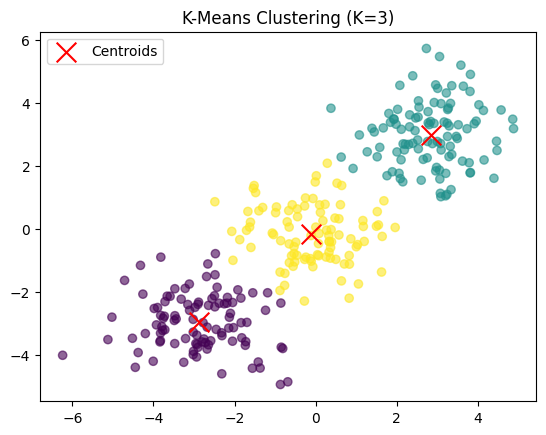

In [25]:
k = 3  # Set number of clusters
centroids, labels = kmeans(X, k)

# Final visualization of K-Means results
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', marker='o', alpha=0.6)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=200, label='Centroids')
plt.title("K-Means Clustering (K=3)")
plt.legend()
plt.show()

## K-Means with 2 features

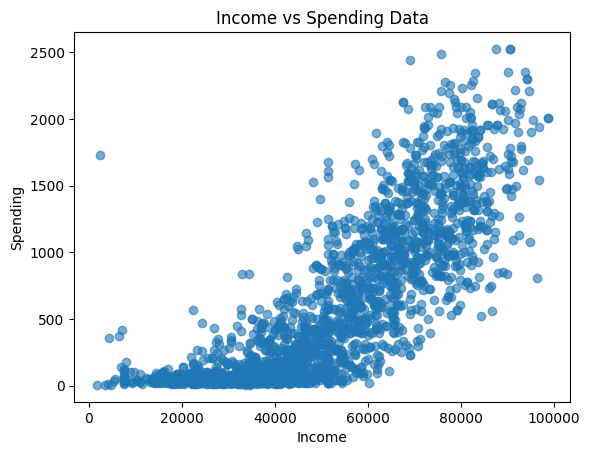

In [26]:
X = df_top_2.values

# Plot the data
plt.scatter(X[:, 0], X[:, 1], marker='o', alpha=0.6)
plt.title("Income vs Spending Data")
plt.xlabel('Income')
plt.ylabel('Spending')
plt.show()

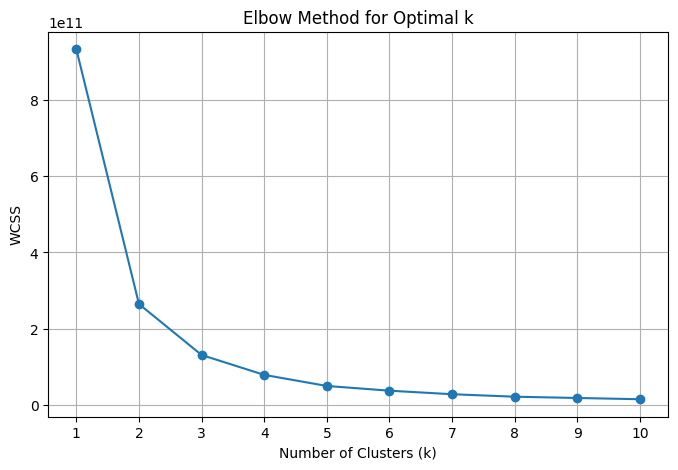

In [27]:
max_k = 10
wcss = calculate_wcss(X, max_k)

# Plotting the Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(range(1, max_k + 1), wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.xticks(range(1, max_k + 1))
plt.grid()
plt.show()

In [28]:
k = 3  # Set number of clusters
centroids, labels = kmeans(X, k, verbose=True)

Initial centroids:
[[82300.34719663   521.56042445]
 [40275.46999888   743.73228026]
 [66565.65824877  2263.76626267]]

Iteration 1:

Closest centroid for each point:
[2 1 2 ... 2 2 1]

Distances to closest centroids:
[ 8452.43930216  6110.70875889  5262.04401407 ...  9639.07280675
  3032.72962742 12606.50132627]

New centroids after updating:
[[81844.89355742  1446.58543417]
 [35363.42724979   180.64928511]
 [63817.26548673   904.18879056]]

Iteration 2:

Closest centroid for each point:
[2 1 2 ... 2 2 2]

Distances to closest centroids:
[ 5723.82357249 10981.64769174  7796.78837519 ...  6844.55751644
  5428.07940387 10972.7215217 ]

New centroids after updating:
[[81089.57506361  1436.12722646]
 [33149.82392344   143.81818182]
 [61099.33715013   800.98600509]]

Iteration 3:

Closest centroid for each point:
[2 1 0 ... 2 2 2]

Distances to closest centroids:
[ 3071.70906119 13194.693207    9499.53908837 ...  4141.77657507
  8145.7711998   8254.33661776]

New centroids after updating:


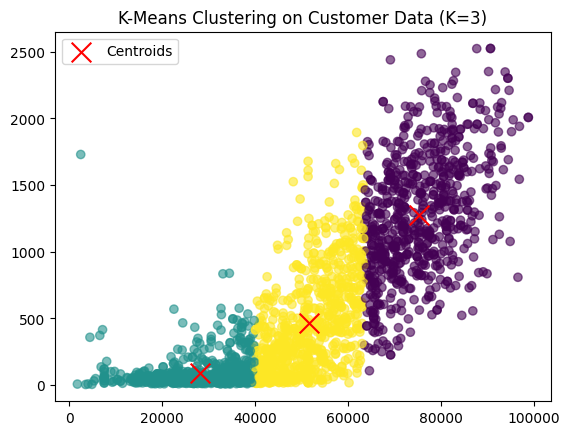

In [29]:
# Final visualization
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', marker='o', alpha=0.6)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=200, label='Centroids')
plt.title("K-Means Clustering on Customer Data (K=3)")
plt.legend()
plt.show()

In [30]:
# Create a temporary DataFrame with the cluster labels
cluster_labels_df = pd.DataFrame(labels, columns=['Cluster'], index=df_top_2.index[:len(labels)])

# Concatenate the temporary DataFrame with the original DataFrame using the index
df_top_2 = pd.concat([df_top_2, cluster_labels_df], axis=1)

# Display the updated DataFrame
df_top_2

,Income,Spending,Cluster
0,58138.0,1617,2
1,46344.0,27,2
2,71613.0,776,0
3,26646.0,53,1
4,58293.0,422,2
...,...,...,...
2235,61223.0,1341,2
2236,64014.0,444,0
2237,56981.0,1241,2
2238,69245.0,843,0


## K-Means with 3 features

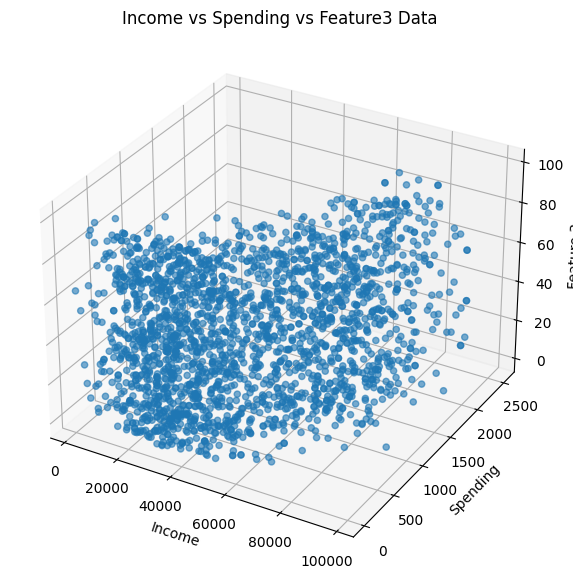

In [31]:
X = df_top_3.values

# Plot the data in 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], marker='o', alpha=0.6)
ax.set_title("Income vs Spending vs Feature3 Data")
ax.set_xlabel('Income')
ax.set_ylabel('Spending')
ax.set_zlabel('Feature 3')  # Update this label according to your feature
plt.show()

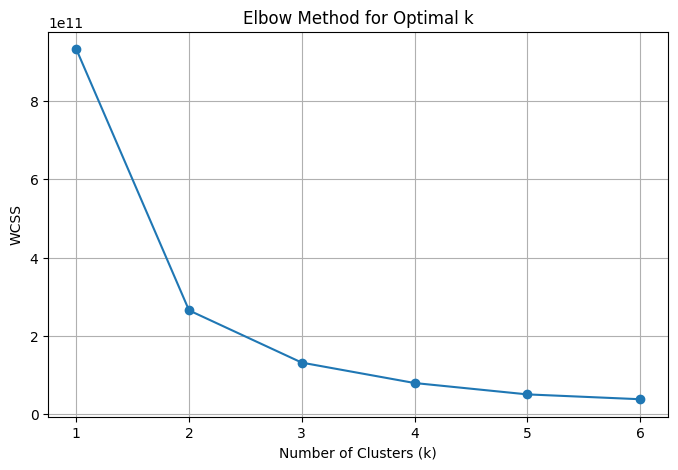

In [32]:
max_k = 6
wcss = calculate_wcss(X, max_k)

# Plotting the Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(range(1, max_k + 1), wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.xticks(range(1, max_k + 1))
plt.grid()
plt.show()

In [33]:
k = 3  # Set number of clusters
centroids, labels = kmeans(X, k, verbose=True)

Initial centroids:
[[6.02641028e+04 7.32508217e+02 2.94150498e+01]
 [2.55403950e+04 9.01295245e+02 5.60740594e+01]
 [3.95099715e+04 1.81699568e+03 4.71289898e+01]]

Iteration 1:

Closest centroid for each point:
[0 2 0 ... 0 0 0]

Distances to closest centroids:
[ 2302.92331432  7064.56750395 11348.98108176 ...  3322.81813842
  8981.60242615  7416.32162479]

New centroids after updating:
[[6.79019470e+04 1.01712222e+03 4.94965812e+01]
 [2.33002851e+04 7.33245614e+01 4.83486842e+01]
 [4.09090970e+04 2.01996656e+02 4.90418060e+01]]

Iteration 2:

Closest centroid for each point:
[0 2 0 ... 0 0 2]

Distances to closest centroids:
[ 9782.36100551  5437.73082079  3718.95231493 ... 10923.32034487
  1354.92872594 11959.94404515]

New centroids after updating:
[[7.05615339e+04 1.11257186e+03 4.90668663e+01]
 [2.30564685e+04 7.32342342e+01 4.89729730e+01]
 [4.31801015e+04 2.53149100e+02 4.93264781e+01]]

Iteration 3:

Closest centroid for each point:
[0 2 0 ... 0 0 2]

Distances to closest cent

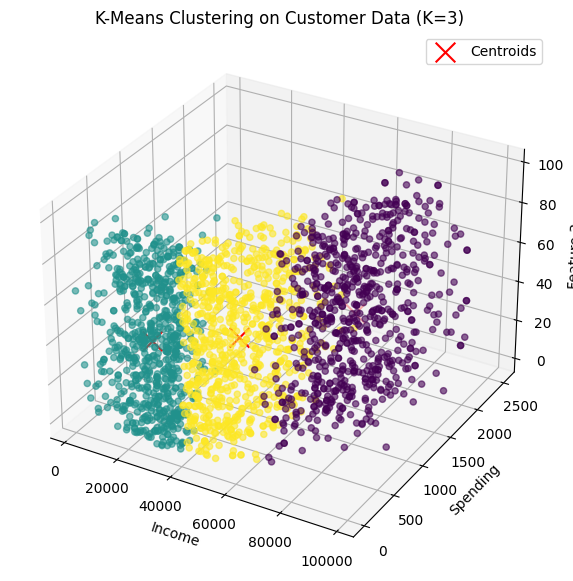

In [34]:
# Final visualization in 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=labels, cmap='viridis', marker='o', alpha=0.6)
ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], c='red', marker='x', s=200, label='Centroids')
ax.set_title("K-Means Clustering on Customer Data (K=3)")
ax.set_xlabel('Income')
ax.set_ylabel('Spending')
ax.set_zlabel('Feature 3')  # Update this label according to your feature
plt.legend()
plt.show()

In [35]:
# Create a temporary DataFrame with the cluster labels
cluster_labels_df = pd.DataFrame(labels, columns=['Cluster'], index=df_top_3.index[:len(labels)])

# Concatenate the temporary DataFrame with the original DataFrame using the index
df_top_3 = pd.concat([df_top_3, cluster_labels_df], axis=1)

# Display the updated DataFrame
df_top_3

,Income,Spending,Recency,Cluster
0,58138.0,1617,58,2
1,46344.0,27,38,2
2,71613.0,776,26,0
3,26646.0,53,26,1
4,58293.0,422,94,2
...,...,...,...,...
2235,61223.0,1341,46,2
2236,64014.0,444,56,0
2237,56981.0,1241,91,2
2238,69245.0,843,8,0


## K-Means with all the features

In [36]:
X = df.values

X.shape

(2224, 15)

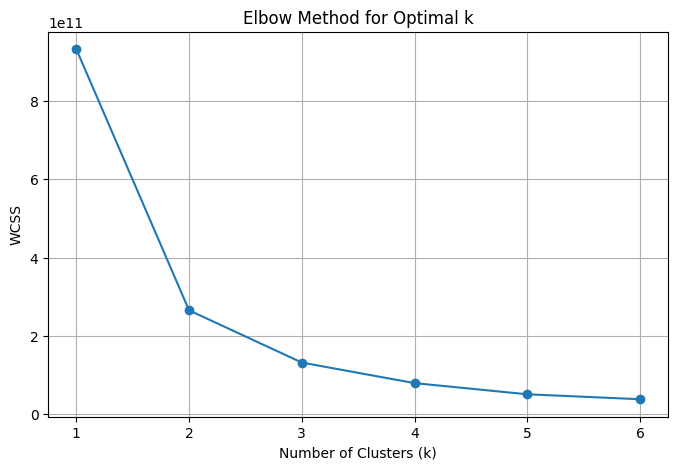

In [37]:
max_k = 6
wcss = calculate_wcss(X, max_k)

# Plotting the Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(range(1, max_k + 1), wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.xticks(range(1, max_k + 1))
plt.grid()
plt.show()

In [38]:
k = 3  # Set number of clusters
centroids, labels = kmeans(X, k, verbose=True)

Initial centroids:
[[5.69918520e+01 4.95226210e+03 3.98147262e-01 7.92580832e+01
  2.68510958e+02 1.26344579e-01 8.11944503e+00 1.92803472e+01
  2.28151032e+01 7.11870089e+00 1.28715539e+01 8.16299820e-02
  3.87752173e+03 3.90346102e+00 5.52788955e+00]
 [3.29205240e+01 9.35580741e+03 1.70262254e+00 1.98148742e+01
  1.60880423e+03 3.74484898e+00 1.06359078e+01 2.16466582e+01
  2.24321570e+00 1.06248710e+01 1.05280532e+01 6.03520840e-02
  4.37537671e+03 1.34758317e+00 4.61095443e+00]
 [4.76351081e+01 4.02502132e+04 2.06839491e+00 1.65807756e+01
  1.78531883e+03 2.07885135e-01 1.30645369e+01 9.16515520e+00
  2.50548664e+01 5.88013770e+00 1.46317904e+01 2.47103234e-01
  3.91923058e+03 7.28471663e-01 3.48737002e+00]]

Iteration 1:

Closest centroid for each point:
[2 2 2 ... 2 2 2]

Distances to closest centroids:
[17895.91048032  6342.66416265 31379.44178008 ... 16739.82937492
 29010.11580784 12730.2063555 ]

New centroids after updating:
[[5.57272727e+01 4.77118182e+03 1.00000000e+00 4.20

In [39]:
# Create a temporary DataFrame with the cluster labels
cluster_labels_df = pd.DataFrame(labels, columns=['Cluster'], index=df.index[:len(labels)])

# Concatenate the temporary DataFrame with the original DataFrame using the index
df= pd.concat([df, cluster_labels_df], axis=1)

# Display the updated DataFrame
df

,Age,Income,Family_Size,Recency,Spending,TotalCampaignsAccepted,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Complain,Tenure,Education,Marital_Status,Cluster
0,67,58138.0,0,58,1617,0,3,8,10,4,7,0,4429,0,0,1
1,70,46344.0,2,38,27,0,2,1,1,2,5,0,3879,0,0,1
2,59,71613.0,0,26,776,0,1,8,2,10,4,0,4078,0,1,2
3,40,26646.0,1,26,53,0,2,2,0,4,6,0,3905,0,1,0
4,43,58293.0,1,94,422,0,5,5,3,6,5,0,3927,1,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,57,61223.0,1,46,1341,0,2,9,3,4,5,0,4147,0,2,1
2236,78,64014.0,3,56,444,1,7,8,2,5,7,0,3785,1,1,2
2237,43,56981.0,0,91,1241,1,1,2,3,13,6,0,3921,0,3,1
2238,68,69245.0,1,8,843,0,2,6,5,10,3,0,3922,2,1,2
